# Основы машинного обучения, ПАДиИИ

## НИУ ВШЭ, 2024-25 учебный год

# Домашнее задание 6: Классификация при помощи CNN

Задание выполнил(а):

Демьянов Степан

## Общая информация

__Внимание!__  


* Домашнее задание выполняется самостоятельно
* Не допускается помощь в решении домашнего задания от однокурсников или третьих лиц. «Похожие» решения считаются плагиатом, и все задействованные студенты — в том числе и те, у кого списали, — не могут получить за него больше 0 баллов
* Использование в решении домашнего задания генеративных моделей (ChatGPT и так далее) за рамками справочной и образовательной информации для генерации кода задания — считается плагиатом, и такое домашнее задание оценивается в 0 баллов
* Старайтесь сделать код как можно более оптимальным. Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

## О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


## Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

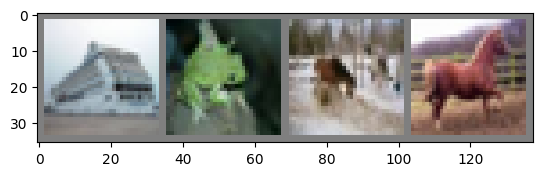

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.avgpool = nn.AvgPool2d(kernel_size=8)

        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        loss_log.append(loss.item())

        _, predicted = torch.max(output, 1)
        correct = (predicted == target).sum().item()
        acc = correct / target.size(0)
        acc_log.append(acc)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())
        _, predicted = torch.max(output, 1)
        correct = (predicted == target).sum().item()
        acc = correct / target.size(0)
        acc_log.append(acc)

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.483363015996037, train acc: 0.4715575215460956
 val loss: 1.4350791084005479, val acc: 0.5067375886524823

Epoch 1
 train loss: 1.155501559077059, train acc: 0.5927706320188039
 val loss: 1.1789553667636627, val acc: 0.5959441489361702

Epoch 2
 train loss: 1.0070035931615116, train acc: 0.6508716375032646
 val loss: 1.00671823557387, val acc: 0.6556515957446809

Epoch 3
 train loss: 0.9253448653264716, train acc: 0.6822563006006791
 val loss: 0.9563481394280778, val acc: 0.6689494680851064

Epoch 4
 train loss: 0.8759236088400567, train acc: 0.6961551645338209
 val loss: 0.8855249544407459, val acc: 0.6892508865248226

Epoch 5
 train loss: 0.8380672614578791, train acc: 0.7064670932358318
 val loss: 0.862490974588597, val acc: 0.7071808510638298

Epoch 6
 train loss: 0.8049797266449309, train acc: 0.7225083246278401
 val loss: 0.8450033190402578, val acc: 0.707668439716312

Epoch 7
 train loss: 0.7814987406434263, train acc: 0.7295842582919823
 val loss: 0.82678

Посчитайте точность на тестовой выборке:

In [12]:
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.7277


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

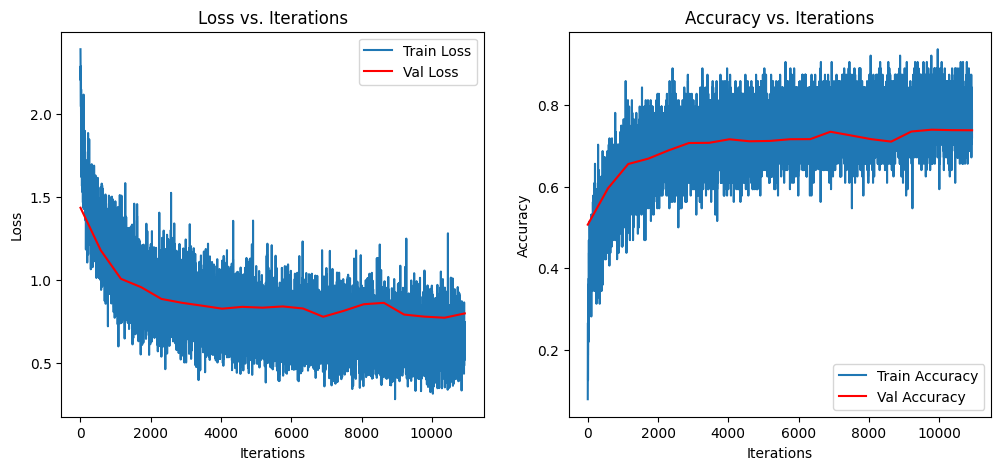

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_log, label='Train Loss')
val_loss_x = np.linspace(0, len(train_loss_log), len(val_loss_log))
plt.plot(val_loss_x, val_loss_log, label='Val Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Iterations')

plt.subplot(1, 2, 2)
plt.plot(train_acc_log, label='Train Accuracy')
val_acc_x = np.linspace(0, len(train_acc_log), len(val_acc_log))
plt.plot(val_acc_x, val_acc_log, label='Val Accuracy',  color='red')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Iterations')
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [14]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.432868900748014, train acc: 0.4867418059545574
 val loss: 1.185338028694721, val acc: 0.5902925531914893

Epoch 1
 train loss: 1.0890749554529486, train acc: 0.6208009597806216
 val loss: 1.1094911539808232, val acc: 0.6192819148936171

Epoch 2
 train loss: 0.9759024225815559, train acc: 0.6577884238704623
 val loss: 1.0286517630232141, val acc: 0.644636524822695

Epoch 3
 train loss: 0.9064104357628762, train acc: 0.6828398406894751
 val loss: 0.9082373918370997, val acc: 0.6830230496453902

Epoch 4
 train loss: 0.8689062767534413, train acc: 0.6985913423870462
 val loss: 0.8927403840612858, val acc: 0.6889849290780141

Epoch 5
 train loss: 0.827153143760709, train acc: 0.713669528597545
 val loss: 0.8540675721269972, val acc: 0.7082890070921987

Epoch 6
 train loss: 0.8046235126158873, train acc: 0.7180440389135544
 val loss: 0.8616440458500639, val acc: 0.7086214539007093

Epoch 7
 train loss: 0.7768448739426663, train acc: 0.7294414337947245
 val loss: 0.8609

Посчитайте точность на тестовой выборке:

In [15]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 75.47%


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [17]:
def train_and_evaluate_config(lr, weight_decay=0.0, epochs=20):
    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    for epoch in range(epochs):
        net.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"LR={lr}, WD={weight_decay}: Test Accuracy: {accuracy:.2f}%")


print("Результат с постоянным LR=0.001:")
train_and_evaluate_config(lr=0.001, weight_decay=0.0)

print("\nРезультат с расписанием LR (0.1 -> 0.01 -> 0.001): 75%")

Результат с постоянным LR=0.001:
LR=0.001, WD=0.0: Test Accuracy: 69.91%

Результат с расписанием LR (0.1 -> 0.01 -> 0.001): 75%


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [26]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [27]:
configs = [
    {'name': 'StepLR', 'scheduler': optim.lr_scheduler.StepLR, 'params': {'step_size': 5, 'gamma': 0.5}},
    {'name': 'ExponentialLR', 'scheduler': optim.lr_scheduler.ExponentialLR, 'params': {'gamma': 0.9}},
    {'name': 'ReduceLROnPlateau', 'scheduler': optim.lr_scheduler.ReduceLROnPlateau, 'params': {'mode': 'max', 'patience': 2}},
]

results = {}

for cfg in configs:
    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = cfg['scheduler'](optimizer, **cfg['params'])

    print(f"\nTraining with {cfg['name']}...")
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
        net, optimizer, 20, train_loader, val_loader, scheduler
    )

    test_loss, test_acc = test(net, test_loader)
    results[cfg['name']] = test_acc
    print(f"{cfg['name']} Test Accuracy: {test_acc:.4f}")


for method, acc in results.items():
    print(f"{method}: {acc:.4f}")


Training with StepLR...
Epoch 0
 train loss: 1.5671442949793675, train acc: 0.4399198550535388
 val loss: 1.4438299620405157, val acc: 0.48167109929078017

Epoch 1
 train loss: 1.2993005223204492, train acc: 0.5343962196395925
 val loss: 1.2503325540968713, val acc: 0.5518617021276596

Epoch 2
 train loss: 1.186785046426644, train acc: 0.578137242099765
 val loss: 1.1768357834917433, val acc: 0.5820478723404255

Epoch 3
 train loss: 1.1039700802327075, train acc: 0.6115989814572996
 val loss: 1.0727507497401947, val acc: 0.6205230496453902

Epoch 4
 train loss: 1.0515033771612528, train acc: 0.6287542439279186
 val loss: 1.0604727646137806, val acc: 0.6267508865248226

Epoch 5
 train loss: 0.9495342190784336, train acc: 0.6673862300861845
 val loss: 0.9348497159937594, val acc: 0.6759086879432625

Epoch 6
 train loss: 0.931443402765002, train acc: 0.6737113149647428
 val loss: 0.9104402641032604, val acc: 0.6835992907801418

Epoch 7
 train loss: 0.9097864573354912, train acc: 0.682794

Your answers here:  
...

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

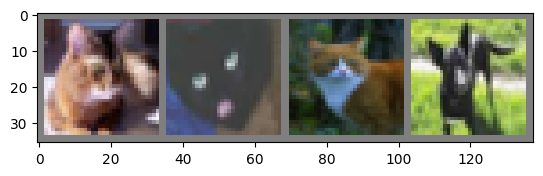

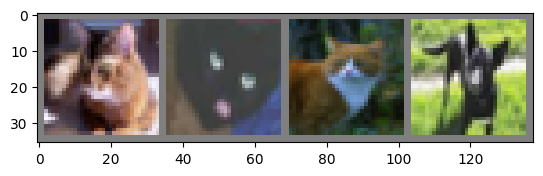

In [20]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [21]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4604713514692387, train acc: 0.4773031470357796
 val loss: 1.245958234908733, val acc: 0.5620567375886524

Epoch 1
 train loss: 1.1239042381263955, train acc: 0.6064450574562549
 val loss: 1.0400133472807864, val acc: 0.6383643617021276

Epoch 2
 train loss: 1.0011044790801444, train acc: 0.6514429354922957
 val loss: 1.0053266380695587, val acc: 0.6506648936170213

Epoch 3
 train loss: 0.9399395417251796, train acc: 0.6737847675633325
 val loss: 0.924444099436415, val acc: 0.6792331560283689

Epoch 4
 train loss: 0.887555865962501, train acc: 0.6926539240010446
 val loss: 0.9073906269479305, val acc: 0.689206560283688

Epoch 5
 train loss: 0.8552645686775501, train acc: 0.7052551253591015
 val loss: 0.9079881891291193, val acc: 0.69375

Epoch 6
 train loss: 0.8218930320613345, train acc: 0.7150161595716897
 val loss: 0.8724639864678079, val acc: 0.7023271276595745

Epoch 7
 train loss: 0.7962134856410611, train acc: 0.7256096565682946
 val loss: 1.00824593787497

Посчитайте точность на тестовой выборке:

In [22]:
net.eval()
correct = total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy after augmentations: {100*correct/total:.2f}%")

Test Accuracy after augmentations: 76.09%


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
aug_configs = {
    'base': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    'with_rotation': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    'with_jitter': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
}

results = {}

for name, transform in aug_configs.items():
    print(f"\nTraining with {name} augmentations...")
    train_loader, val_loader, test_loader = get_cifar10_data(64, transform)

    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

    train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
        net, optimizer, 20, train_loader, val_loader, scheduler
    )

    test_loss, test_acc = test(net, test_loader)
    results[name] = test_acc
    print(f"{name} Test Accuracy: {test_acc:.4f}")


print("\nResults:")
for aug, acc in results.items():
    print(f"{aug}: {acc:.4f}")


Training with base augmentations...
Epoch 0
 train loss: 1.4595237193421429, train acc: 0.4778213959258292
 val loss: 1.2261294532329479, val acc: 0.5677526595744681

Epoch 1
 train loss: 1.1301558648646424, train acc: 0.6060410681640115
 val loss: 1.0361467559286888, val acc: 0.6392952127659575

Epoch 2
 train loss: 1.008405267102627, train acc: 0.6487211086445548
 val loss: 0.9659709014791124, val acc: 0.6612810283687944

Epoch 3
 train loss: 0.9485054819195973, train acc: 0.6717525790023505
 val loss: 0.9653267804612504, val acc: 0.6656028368794327

Epoch 4
 train loss: 0.8992377313660965, train acc: 0.6891649255680334
 val loss: 0.9657783602146393, val acc: 0.6678413120567375

Epoch 5
 train loss: 0.864482442901165, train acc: 0.6998808435622879
 val loss: 0.9138475628609353, val acc: 0.6879875886524822

Epoch 6
 train loss: 0.8313172990268938, train acc: 0.7104865826586576
 val loss: 0.8811028054419984, val acc: 0.6975842198581561

Epoch 7
 train loss: 0.8063111586915074, train a

Your answers here: Да

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
import wandb

wandb.init(project="hw6-cnn", entity="your_username")

config = {
    "lr": 0.1,
    "batch_size": 64,
    "augmentations": "full_aug"
}
wandb.config.update(config)

for epoch in range(20):
    train_loss, train_acc = train_epoch(...)
    val_loss, val_acc = test(...)

    wandb.log({
        "epoch": epoch,
        "train_loss": np.mean(train_loss),
        "train_acc": np.mean(train_acc),
        "val_loss": val_loss,
        "val_acc": val_acc
    })

Ссылка на страницу с графиками:

    (...)